### **Init**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2

import time
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Fri Apr 19 12:04:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P8              10W / 340W |  15470MiB / 16376MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
lr = 1e-3
EPOCH = 500
lambda_ = 1e-4

In [ ]:
train_dir = 'G:/X-Brain/Data/train'
val_dir = 'G:/X-Brain/Data/val'
test_dir = 'G:/X-Brain/Data/test'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
)
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_set.class_indices)
class_labels = list(train_set.class_indices.keys())
class_indices = list(train_set.class_indices.values())

Found 14919 images belonging to 4 classes.
Found 4261 images belonging to 4 classes.
Found 2135 images belonging to 4 classes.


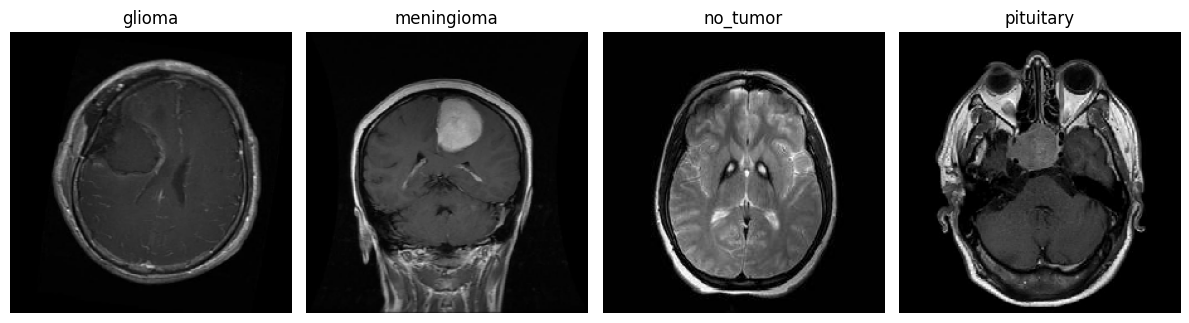

In [ ]:
fig, axes = plt.subplots(1, num_classes, figsize=(12, 5))

for i, class_idx in enumerate(class_indices):
    image_batch, label_batch = next(val_set)
    index = np.where(label_batch[:, class_idx] == 1)[0][0]
    image = image_batch[index]

    axes[i].imshow(image)
    axes[i].set_title(class_labels[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### **Model**

In [ ]:
def ConvBlock(x, units=32, kernel_size=3, strides=1, padding='same'):
    x = layers.Conv2D(units, kernel_size, strides, padding, kernel_regularizer=L2(lambda_))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def DepthwiseConvBlock(x, units=32, kernel_size=3, strides=1, padding='same'):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(units, 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def ResidualAttentionBlock(x, units):
    res = x

    a = ConvBlock(x, units)
    a = ConvBlock(a, units)
    a = layers.MultiHeadAttention(num_heads=1, key_dim=units, value_dim=units)(a, a)

    b = ConvBlock(x, units)
    b = ConvBlock(b, units)
    b = layers.MultiHeadAttention(num_heads=1, key_dim=units, value_dim=units)(b, b)

    x = layers.Concatenate()([a, b])
    x = DepthwiseConvBlock(x, units)
    x = ConvBlock(x, units)
    x = layers.Add()([x, res])

    return x

In [ ]:
def model_architecture():
    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    p = ConvBlock(inputs, 16, strides=2)
    p = DepthwiseConvBlock(p, 32)

    q = ConvBlock(inputs, 16, strides=2)
    q = DepthwiseConvBlock(q, 32)

    x = layers.Concatenate()([p, q])
    x = ConvBlock(x, 64, strides=2)
    x = ResidualAttentionBlock(x, 64)

    x = ConvBlock(x, 64, strides=2)
    x = ConvBlock(x, 64)

    x = DepthwiseConvBlock(x, 128)
    x = ConvBlock(x, 128, strides=2)
    x = ConvBlock(x, 128)

    x = DepthwiseConvBlock(x, 256)
    x = ConvBlock(x, 256, strides=2)
    x = ConvBlock(x, 256)

    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name="x_brain")
    model.summary()
    return model

model = model_architecture()
model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "x_brain"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 112, 112, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 112, 112, 16  448         ['input_3[0][0]']                
                                )                                                           

In [ ]:
checkpoint_filepath = 'G:/X-Brain/Checkpoints/X-Brain.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
plateau_lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0000001,
)
bas_kar_bhai = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='auto'
)

In [ ]:
t1=time.time()

history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=EPOCH,
    callbacks=[model_checkpoint_callback, plateau_lr_reduction, bas_kar_bhai]
)

# Training time
t2=time.time()
print(f'Training Time : {round((t2-t1)/60)}minutes')

# selecting the best model
model.load_weights(checkpoint_filepath)
print("Best weights restored!!")

Epoch 1/500
467/467 [==============================] - ETA: 0s - loss: 0.9867 - accuracy: 0.6573
Epoch 1: val_accuracy improved from -inf to 0.30040, saving model to G:/X-Brain/Checkpoints\X-Brain.weights.h5
467/467 [==============================] - 140s 294ms/step - loss: 0.9867 - accuracy: 0.6573 - val_loss: 2.4538 - val_accuracy: 0.3004 - lr: 0.0010
Epoch 2/500
467/467 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.8056
Epoch 2: val_accuracy improved from 0.30040 to 0.76531, saving model to G:/X-Brain/Checkpoints\X-Brain.weights.h5
467/467 [==============================] - 137s 293ms/step - loss: 0.6494 - accuracy: 0.8056 - val_loss: 0.7468 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 3/500
467/467 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.8528
Epoch 3: val_accuracy did not improve from 0.76531
467/467 [==============================] - 137s 292ms/step - loss: 0.5338 - accuracy: 0.8528 - val_loss: 0.7778 - val_accuracy: 0.7423 - 

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
print("Training Loss:\n", training_loss)
print("Validation Loss:\n", validation_loss)
print("Training Accuracy:\n", training_accuracy)
print("Validation Accuracy:\n", validation_accuracy)

Training Loss:
 [0.986665666103363, 0.6493767499923706, 0.5338176488876343, 0.4833284914493561, 0.42754775285720825, 0.4029292166233063, 0.38674768805503845, 0.3696100115776062, 0.3617073595523834, 0.34594786167144775, 0.34444552659988403, 0.27464842796325684, 0.25906088948249817, 0.2531387507915497, 0.253924697637558, 0.24071259796619415, 0.23088207840919495, 0.22971217334270477, 0.19670158624649048, 0.1807401180267334, 0.17383931577205658, 0.17489418387413025, 0.17131154239177704, 0.16745424270629883, 0.16469790041446686, 0.15846370160579681, 0.15230035781860352, 0.15900596976280212, 0.14715299010276794, 0.1488419622182846, 0.14070625603199005, 0.13985837996006012, 0.14714409410953522, 0.1425940990447998, 0.13511735200881958, 0.1352671980857849, 0.13719335198402405, 0.13192865252494812, 0.12551507353782654, 0.11293085664510727, 0.10922478139400482, 0.1048230230808258, 0.10590831190347672, 0.10419126600027084, 0.10229778289794922, 0.10176055878400803, 0.09966199845075607, 0.1016169264

In [ ]:
plt.rcdefaults()

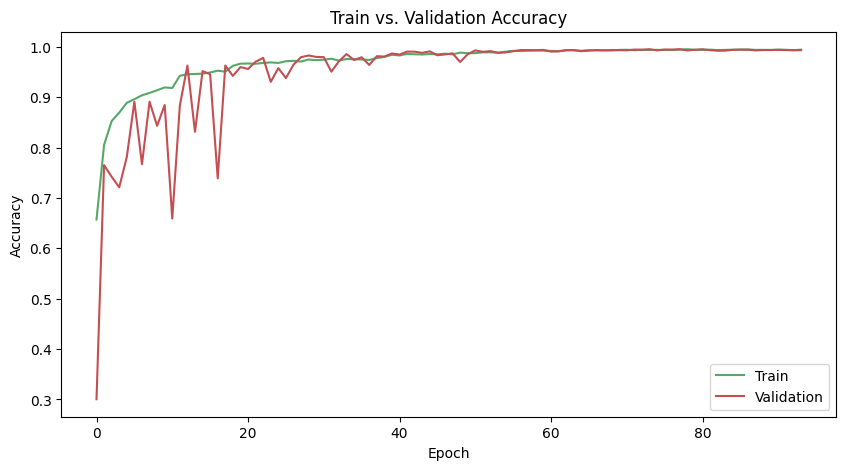

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy,'g', label='Train')
plt.plot(validation_accuracy,'r', label='Validation')
plt.title('Train vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('x-brain_train-val_acc_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

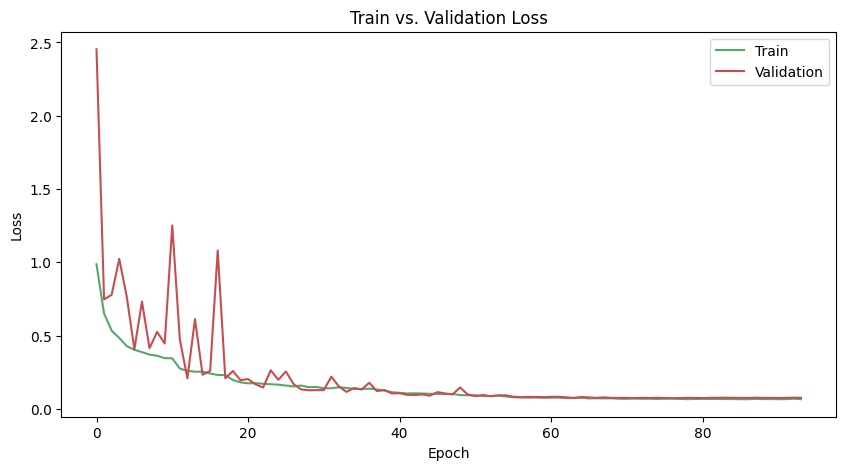

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(training_loss,'g', label='Train')
plt.plot(validation_loss,'r', label='Validation')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('x-brain_train-val_loss_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_set)
val_loss, val_acc = model.evaluate(val_set)
test_loss, test_acc = model.evaluate(test_set)

print(f"Train Accuracy : {train_acc}")
print(f"Train Loss : {train_loss}")
print("-------------")
print(f"Val Accuracy : {val_acc}")
print(f"Val Loss : {val_loss}")
print("-------------")
print(f"Test Accuracy : {test_acc}")
print(f"Test Loss : {test_loss}")

67/67 [==============================] - 8s 117ms/step - loss: 0.0763 - accuracy: 0.9930
Train Accuracy : 0.998056173324585
Train Loss : 0.0589049756526947
-------------
Val Accuracy : 0.995540976524353
Val Loss : 0.0738973617553711
-------------
Test Accuracy : 0.9929742217063904
Test Loss : 0.07626553624868393


In [ ]:
predictions = model.predict(test_set)
predicted_labels = tf.argmax(predictions, axis=1)

true_labels = test_set.classes

class_report = classification_report(true_labels, predicted_labels, target_names=class_labels, digits=6)
print(class_report)

67/67 [==============================] - 6s 85ms/step
              precision    recall  f1-score   support

      glioma   0.994141  0.984526  0.989310       517
  meningioma   1.000000  0.989031  0.994485       547
    no_tumor   0.992352  1.000000  0.996161       519
   pituitary   0.985689  0.998188  0.991899       552

    accuracy                       0.992974      2135
   macro avg   0.993045  0.992936  0.992964      2135
weighted avg   0.993022  0.992974  0.992971      2135



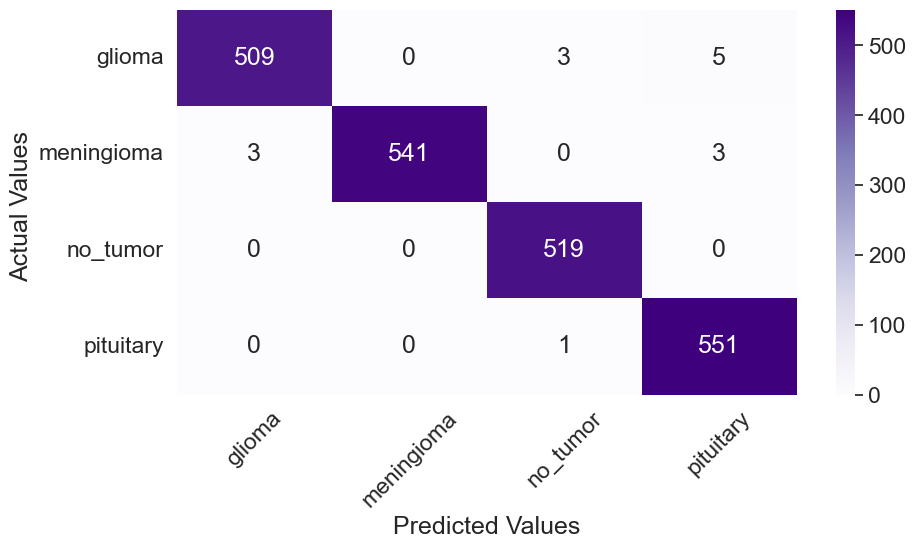

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
class_names = class_labels

plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, xticklabels=class_names, yticklabels=class_names)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

plt.savefig('x-brain_cm_test.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model.save('X-Brain.keras')